###Standard MoE Implementation and Training

####**Expert Module**
- MLP with GELU
####**Standard MoE Layer**
- Router
- Top-K Selection
- Expert Processing
- Weighted Combinations of Expert Outputs to router probabilities
- Auxiliary Load Balancing Loss
####**Training**
- N Experts to match the parameter count with DSMoE
- Top-2 routing
- Auxiliary load balancing loss
- Mixed precision float16

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import math, os, time

from contextlib import nullcontext
from dataclasses import dataclass

import numpy as np
from datasets import load_dataset
import tiktoken
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Configure Training parameters including batch_size, context_length, learning rate

In [ ]:
''' global training confgiurations '''
batch_size = 32     # number of seq in the batch
block_size = 256    # context length of the model
max_iters = 5000    # training iterations
eval_interval = 250 # how often to eval and print the loss
eval_iters = 100    # 3e-4 # number of batch to average the validation loss
learning_rate = 3e-4# max learning rate
min_lr = 3e-5       # min learning rate after cosine decay
warmup_iters = 200  # iterations for learning rate warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu' # device configuration
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # improve training speed on compatible GPUs while maintaining numerical stability
ptdtype = {'float16': torch.float16, 'bfloat16': torch.bfloat16, 'float32': torch.float32}[dtype]
ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type='cuda', dtype=ptdtype)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

Define the **MoE model Config class** for the model's architecture

In [ ]:
''' Base Model Architecture Configuration '''
@dataclass
class BaseModelConfig:
    # transformer parameters, 6 layers with 8 attention heads each, 512 embedding dimension, and context length of 256 tokens
    n_layer: int = 6
    n_head: int = 8
    n_embd: int = 512
    vocab_size: int = 50257
    block_size: int = block_size
    dropout: float = 0.1
    bias: bool = False
    # MoE parameters for fine-grained experts
    moe_n_routed_experts: int = 16
    moe_top_k: int =2
    moe_expert_hidden_dim: int = 512
    # shared expert isolation
    moe_n_shared_experts: int = 2
    moe_shared_expert_hidden_dim: int = 1024

model_config = BaseModelConfig()
print('Model Configuration')
print(f'Devide: {device} with dtype {dtype}')
print(f'Model {model_config.n_layer} layers, {model_config.n_head} heads, {model_config.n_embd} embedding dimension' )
print(f'MoE: {model_config.moe_n_routed_experts} routed experts top {model_config.moe_top_k} + {model_config.moe_n_shared_experts} shared experts')


Model Configuration
Devide: cuda with dtype bfloat16
Model 6 layers, 8 heads, 512 embedding dimension
MoE: 16 routed experts top 2 + 2 shared experts


Dataset and Tokenizer configuration - use tinystories dataset that are more suitable for language modeling tasks. Tokenize the data with GPT-2 tokenizer from tiktoken

In [ ]:
dataset_name = "roneneldan/TinyStories" # split="train"
train_file = '/content/train.bin'
val_file = '/content/val.bin'
tokenizer_model = 'gpt2'

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

Process data once, and then efficiently load random batches during training

In [ ]:
if not os.path.exists(train_file) and not os.path.exists(val_file):
    ds = load_dataset(dataset_name)
    encoded = tiktoken.get_encoding(tokenizer_model)
    assert encoded.max_token_value < 2**16, 'tokenizer vocab is too large'

    def process_and_tokenize(sample):
        ids = encoded.encode_ordinary(sample['text']) #[:base_config.block_size]
        return {'ids': ids, 'len': len(ids)}

    #  tokenize the dataset in parallel
    tokenized_ds = ds.map(
        process_and_tokenize,
        remove_columns = ['text'],
        desc = 'tokenizing dataset/splits',
        num_proc = os.cpu_count(),
    )

    for split, d_set in tokenized_ds.items():
        split_name = 'val' if split == 'validation' else split
        filename = f"/content/{split_name}.bin"
        total_tokens = np.sum(d_set['len'], dtype=np.uint64)
        arr = np.memmap(filename, dtype=np.uint16, mode='w+', shape=(total_tokens,))
        print(f'writing tokens to {filename} ')
        idx = 0
        for batch in tqdm(d_set, desc=f'writing {split_name} data'):
            arr[idx:idx + batch['len']] = batch['ids']
            idx += batch['len']
        arr.flush()
    print('tokenization and file writing is complete')

In [ ]:
''' Data loading for training '''
def get_batch(split):
    filename = train_file if split == 'train' else val_file
    data = np.memmap(filename, dtype=np.uint16, mode='r')
    idx = np.random.randint(len(data) - model_config.block_size, size=(batch_size,))
    x = torch.stack([torch.from_numpy(
        (data[i:i+model_config.block_size]).astype(np.int64)) for i in idx])
    y = torch.stack([torch.from_numpy(
        (data[i+1:i+1+model_config.block_size]).astype(np.int64)) for i in idx])
    return x.to(device), y.to(device)

MultiHeadAttention

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    '''
    Multi-head self attention mechanism as in the Transformer
    '''
    def __init__(self, config: BaseModelConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0, 'ds model divisible by num_heads'
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.resid_dropout = nn.Dropout(config.dropout)

        # Flash attention-based scaled dot product attention
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print('WARNING: using slow attention. Flash attention requires PyTorch >= 2.0')
            self.register_buffer('bias', torch.tril(torch.ones(block_size,  block_size)).view(1, 1, model_config.block_size, model_config.block_size))

    def forward(self, x, kv_cache=None):
        B, T, C = x.size()
        head_size = C // self.n_head
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_size).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0.0, is_causal=(kv_cache is None))
        else:
            attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            attn = attn.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            attn = F.softmax(attn, dim=-1)
            attn = self.resid_dropout(attn)
            y = attn @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

MoE Core Architecture - MoE Baseline Model

In [ ]:
class Expert(nn.Module):
    def __init__(self, n_embd: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, hidden_dim, bias=False),
            nn.GELU(),
            nn.Linear(hidden_dim, n_embd, bias=False),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class MoElayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_routed_experts = config.moe_n_routed_experts
        self.top_k = config.moe_top_k
        self.experts = nn.ModuleList([Expert(config.n_embd, config.moe_expert_hidden_dim, dropout=config.dropout) for _ in range(self.n_routed_experts)])
        self.router = nn.Linear(config.n_embd, self.n_routed_experts, bias=False)
        self.aux_loss_coeff = 1e-2

    def forward(self, x: torch.Tensor):
        B, T, C = x.shape
        x_flat = x.view(-1, C)
        num_tokens = x_flat.shape[0]

        router_logits = self.router(x_flat)
        routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
        topk_weights, topk_indices = torch.topk(routing_weights, k=self.top_k, dim=1)
        gates = topk_weights / topk_weights.sum(dim=1, keepdim=True)

        # auxiliary load balancing loss - calculate f_i and p_i for each expert
        expert_counts = torch.zeros(self.n_routed_experts, dtype=torch.float, device=x.device)
        expert_counts.index_add_(0, topk_indices.view(-1), torch.ones_like(topk_indices.view(-1), dtype=torch.float, device=x.device))
        f_i = expert_counts / num_tokens
        p_i = routing_weights.mean(dim=0)
        # auxiliary loss the dot product distribution of these scaled
        aux_loss = self.n_routed_experts * torch.sum(p_i * f_i) * self.aux_loss_coeff

        # dispatch tokens
        final_output_flat = torch.zeros_like(x_flat)
        for i in range(self.n_routed_experts):
            mask = (topk_indices == i)
            row_idx, which_k = mask.nonzero(as_tuple=True)
            if row_idx.numel() == 0: continue

            expert_in = x_flat.index_select(0, row_idx.long())
            expert_out = self.experts[i](expert_in)
            gate_values = gates[row_idx, which_k].unsqueeze(1)

            final_output_flat.index_add_(0, row_idx.long(), expert_out * gate_values)

        return final_output_flat.view(B, T, C), aux_loss

In [ ]:
class MoEBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.moe_layer = MoElayer(config)

    def forward(self, x: torch.Tensor):
        x = x + self.attn(self.ln_1(x))
        moe_out, aux_loss = self.moe_layer(self.ln_2(x))
        x = x + moe_out
        return x, aux_loss

In [ ]:
test_config = BaseModelConfig #DeepSeekMoEConfig()
ds_input = torch.randint(0, test_config.vocab_size, (batch_size, test_config.block_size))
embeddiing_layer = nn.Embedding(test_config.vocab_size, test_config.n_embd)
ds_input_embedded = embeddiing_layer(ds_input)
mha = DS_MultiHeadAttention(test_config)
ds_output = mha(ds_input_embedded)
ds_input.shape, ds_input_embedded.shape, ds_output.shape

(torch.Size([32, 256]), torch.Size([32, 256, 512]), torch.Size([32, 256, 512]))

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [ ]:
class MoEGPT(nn.Module):
    def __init__(self, config: BaseModelConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([MoEBlock(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for param_name , param in self.named_parameters():
            if param_name.endswith('c_proj.weight'):
                torch.nn.init.normal_(param, mean=0.0, std=0.02/math.sqrt(2 *config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size, 'context length exceeded'
        position = torch.arange(0, T, dtype=torch.long, device=idx.device)

        token_emb = self.transformer.wte(idx)
        position_emb = self.transformer.wpe(position)
        x = self.transformer.drop(token_emb + position_emb)

        total_aux_loss = 0.0
        for block in self.transformer.h:
            x, aux_loss = block(x)
            total_aux_loss += aux_loss
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            main_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            total_loss = main_loss + total_aux_loss / self.config.n_layer
        else:
            logits = self.lm_head(x[:, [-1], :])
            total_loss = None

        return logits, total_loss

    def get_num_params(self, non_embedding=True):
        total_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            total_params -= self.transformer.wte.weight.numel()
        return total_params

In [ ]:
moe_config = BaseModelConfig()
moe_config.moe_n_routed_experts = 22

moe_model = MoEGPT(moe_config).to(device)
input = torch.randint(0, moe_config.vocab_size, (batch_size, moe_config.block_size), device=device )
logits, loss = moe_model(input, input)
print(f'input forward pass successful - logits shape {logits.shape}, loss {loss}')
print(f'total model parameters: {moe_model.get_num_params()/1e6}')
print('MoE defined and verified')

input forward pass successful - logits shape torch.Size([32, 256, 50257]), loss 10.756421089172363
total model parameters: 75.702784
MoE defined and verified


**Training**

In [ ]:
moe_config = BaseModelConfig()
moe_config.moe_n_routed_experts = 22

optimizer = torch.optim.AdamW(moe_model.parameters(), lr=learning_rate)
moe_model = MoEGPT(moe_config)
moe_model.to(device)

In [ ]:
def get_lr(it):
    ''' learning rate scheduler '''
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it >= max_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (max_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

In [ ]:
''' loss estimation '''
@torch.no_grad()
def estimate_loss():
    moe_model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            with ctx:
                logits, loss = moe_model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    moe_model.train()
    return out

In [ ]:
''' training loop '''
print('MoE training ')
train_losses, val_losses = [], []
start_time = time.time()

for iter_num in range(max_iters):
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        val_loss = losses['val']
        val_losses.append(losses['val'])
        train_losses.append(losses['train'])
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    with ctx:
        logits, loss = moe_model(xb, yb)
    del xb, yb

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)

    if iter_num %2 ==0:
        torch.cuda.empty_cache()

end_time = time.time()
moe_train_time = (end_time - start_time)
print(f'training time: {moe_train_time}')

comparison_results = {}
comparison_results['moe'] = {
    'model': moe_model.cpu(),
    'train_time': moe_train_time,
    'val_losses': val_losses,
}
print('Completed training and saved the results')

In [ ]:
'''
torch.cuda.empty_cache()
cp.get_default_memory_pool().free_all_blocks()
import gc
gc.collect()
'''

In [ ]:
end_time = time.time()
ds_moe_train_time = (end_time - start_time)
print(f'training time: {ds_moe_train_time}')
comparison_results = {}
comparison_results['ds_moe'] = {
    'model': ds_moe_model.cpu(),
    'train_time': ds_moe_train_time,
    'val_losses': val_losses,
}
print('Completed training and saved the results')

training time: 7773.333505868912
Completed training and saved the results


plotting validation loss


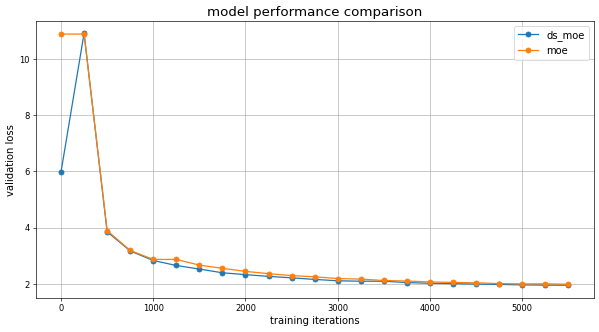

In [ ]:
print('plotting validation loss')
plt.figure(figsize=(12,6), dpi=60)
for model_name, results in comparison_results.items():
    val_losses = results['val_losses']
    steps = [i* eval_interval for i in range(len(val_losses))]
    plt.plot(steps, val_losses, marker='o', linestyle='-', label=model_name)

plt.title('model performance comparison', fontsize=16)
plt.xlabel('training iterations', fontsize=12)
plt.ylabel('validation loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
#plt.ylim(top=4.0, bottom=min(min(v['val_losses']) for v in comparison_results.values()))
plt.show()